*Known Issues - pls fix*
- TODO: Sample size is small - need to duplicate transformed photos with data augmentation (prevent overfitting + better for transfer learning)

In [362]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

import math

## Step 1: Calculate efficiency gaps for previous statewide election returns - this will serve as our target feature.

This dataset contains information on election results for statewide representative elections. This dataset uses the democratic party as the centerpiece party; the resulting effiency gap metric can be directionally interpreted - positive values favor the democratic party, while negative values favor the conservative party (known as GOP party).

Note: There are several reasons why congressional representative elections are used instead of presidential results:
1. There are third-party candidates in presidential elections that often steal sizeable votes away from either major party
2. Presidential election results by congressional district were not widely recorded until the 1970s ([MIT](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/42MVDX)).
3. Congressional elections are less prone to "strategic voting", as congressional representatives (serving in the House of Representatives) directly represent the interest of the district.

In [363]:
df = pd.read_csv("data\congressional_election_results_post1948.csv")

df.shape

(15228, 8)

In [364]:
# Remove erroneous districts - both sides have 0 votes
df = df[~(df["Dem Votes"] == df["GOP Votes"])]

# Remove 6 states with only 1 voting district - these states can't be gerrymandered
single_district_states = ["AK", "DE", "ND", "SD", "VT", "WY"]
df = df[~df["State"].isin(single_district_states)]

In [365]:
df.shape

(14991, 8)

In [366]:
df.head()

,State,Year,District,Dem Votes,GOP Votes,D Voteshare,Incumbent,Party
0,AL,1948,1,19778,0,1.000000,1,D
1,AL,1948,2,21271,0,1.000000,1,D
2,AL,1948,3,16279,0,1.000000,1,D
3,AL,1948,4,17282,3054,0.849823,1,D
4,AL,1948,5,20548,0,1.000000,1,D


In [367]:
df = df.drop(columns="Incumbent")

Creating efficiency gap metric (Methodology found [here](https://www.brennancenter.org/sites/default/files/legal-work/How_the_Efficiency_Gap_Standard_Works.pdf))

The process is as follows:  
1. Calculate "net wasted votes" for each district - the net amount wasted votes from each party (defined below/in README)
2. Sum the net wasted votes across all districts in a state
3. Divide net wasted votes by total votes

In [368]:
df["total_votes"] = df["Dem Votes"] + df["GOP Votes"]

In [369]:
# Net wasted votes = (wasted votes by winning party - 50+1 majority) - all votes by losing party

def net_wasted_votes(democrat_votes, gop_votes):

    majority = math.floor((democrat_votes + gop_votes) / 2) + 1 # required votes for majority  

    if democrat_votes >= gop_votes: 
        return (democrat_votes - majority) - gop_votes 
    else: 
        return -(gop_votes - majority) + democrat_votes 
        

In [370]:
# Positive values indicate wasted votes for democrats, negative values indicate wasted votes for republicans

df["net_wasted_votes"] = df.apply(lambda x: net_wasted_votes(x["Dem Votes"], x["GOP Votes"]), axis=1)

In [371]:
df.head(20)

,State,Year,District,Dem Votes,GOP Votes,D Voteshare,Party,total_votes,net_wasted_votes
0,AL,1948,1,19778,0,1.000000,D,19778,9888
1,AL,1948,2,21271,0,1.000000,D,21271,10635
2,AL,1948,3,16279,0,1.000000,D,16279,8139
3,AL,1948,4,17282,3054,0.849823,D,20336,4059
4,AL,1948,5,20548,0,1.000000,D,20548,10273
5,AL,1948,6,13968,2994,0.823488,D,16962,2492
6,AL,1948,7,21552,0,1.000000,D,21552,10775
7,AL,1948,8,19060,2510,0.883635,D,21570,5764
8,AL,1948,9,33781,5006,0.870936,D,38787,9381
9,AZ,1948,1,42565,29864,0.587679,D,72429,-23514


In [372]:
# Group results by year and state - efficiency gap should be calculated state wide
# each row is one state per election cycle

df_grouped = df.groupby(["Year", "State"]).agg({
    'District': 'count',
    'Dem Votes': 'sum',
    'GOP Votes': 'sum',
    'Party': 'sum',
    'total_votes': 'sum',
    'net_wasted_votes': 'sum'
    }).reset_index()

In [373]:
df_grouped.head()

,Year,State,District,Dem Votes,GOP Votes,Party,total_votes,net_wasted_votes
0,1948,AL,9,183519,13564,DDDDDDDDD,197083,71406
1,1948,AR,7,230927,0,DDDDDDD,230927,115457
2,1948,AZ,2,96631,60004,DD,156635,-41692
3,1948,CA,23,1351731,1976923,RDRDRDRRDRRRRDRRDDDRDRD,3328654,-453818
4,1948,CO,4,272484,224927,DRDD,497411,-62703


In [374]:
df_grouped["efficiency_gap"] = round(df_grouped["net_wasted_votes"] / df_grouped["total_votes"], 2)

In [375]:
df_grouped["D Voteshare"] = round((df_grouped["Dem Votes"] / df_grouped["total_votes"]), 2)

In [376]:
df_grouped["D Seatshare"] = df_grouped["Party"].apply(lambda x: round(x.count("D") / len(x), 2))

In [377]:
df_grouped = df_grouped.drop(columns="Party")

In [378]:
df_grouped.head()

,Year,State,District,Dem Votes,GOP Votes,total_votes,net_wasted_votes,efficiency_gap,D Voteshare,D Seatshare
0,1948,AL,9,183519,13564,197083,71406,0.36,0.93,1.00
1,1948,AR,7,230927,0,230927,115457,0.50,1.00,1.00
2,1948,AZ,2,96631,60004,156635,-41692,-0.27,0.62,1.00
3,1948,CA,23,1351731,1976923,3328654,-453818,-0.14,0.41,0.43
4,1948,CO,4,272484,224927,497411,-62703,-0.13,0.55,0.75


**Positive efficiency gap = better for republicans, negative efficiency gap = better for democrats**

Positive efficiency gap values benefit republicans (lots of net wasted democrat votes), and vice versa

In [379]:
# All voting competitions without empty seats (non-unanimous voting)
df_non_empty = df_grouped[(df_grouped["Dem Votes"] != 0) & (df_grouped["GOP Votes"] != 0)]

# Remove remaining single-district states - cannot be gerrymandered
df_non_empty = df_non_empty[df_non_empty["District"] > 1]

df_non_empty.shape

(1483, 10)

In [380]:
# Large effiency gap values in both directions indicate either "overkill" winning (packing) or close loss (cracking)
df_non_empty.sort_values(by="efficiency_gap")

,Year,State,District,Dem Votes,GOP Votes,total_votes,net_wasted_votes,efficiency_gap,D Voteshare,D Seatshare
297,1960,UT,2,186710,182752,369462,-180775,-0.49,0.51,1.00
1123,1998,NV,2,79315,275163,354478,-171464,-0.48,0.22,0.50
1516,2016,NH,2,336214,315971,652185,-305851,-0.47,0.52,1.00
113,1952,NM,2,241402,221892,463294,-212139,-0.46,0.52,1.00
1428,2012,NH,2,340925,311636,652561,-296993,-0.46,0.52,1.00
...,...,...,...,...,...,...,...,...,...,...
368,1964,MS,5,325950,35277,361227,173391,0.48,0.90,0.80
1109,1998,LA,7,94203,97048,191251,92780,0.49,0.49,0.29
1181,2000,WV,3,420784,108769,529553,259010,0.49,0.79,0.67
43,1950,AL,9,151212,980,152192,74129,0.49,0.99,1.00


Stephanopoulos and McGhee argue that 7% is the threshold for the efficiency gap metric - values higher in magnitude in either direction mean that the state is gerrymandered.

In [381]:
pct_gerrymandered = df_non_empty[(df_non_empty["efficiency_gap"] < -0.07) | (df_non_empty["efficiency_gap"] > 0.07)].shape[0] / df_non_empty.shape[0]
pct_gerrymandered_rep = df_non_empty[(df_non_empty["efficiency_gap"] > 0.07)].shape[0] / df_non_empty.shape[0]
pct_gerrymandered_dem = df_non_empty[(df_non_empty["efficiency_gap"] < -0.07)].shape[0] / df_non_empty.shape[0]


print(f" Percent of states gerrymandered: {round(pct_gerrymandered, 3) * 100}%")
print(f" Percent of states gerrymandered in favor of Republicans: {round(pct_gerrymandered_rep, 3) * 100}%")
print(f" Percent of states gerrymandered in favor of Democrats: {round(pct_gerrymandered_dem, 3) * 100}%")

 Percent of states gerrymandered: 62.2%
 Percent of states gerrymandered in favor of Republicans: 39.4%
 Percent of states gerrymandered in favor of Democrats: 22.7%


Text(0.5, 1.0, 'Bidirectional Efficiency Gap Histogram')

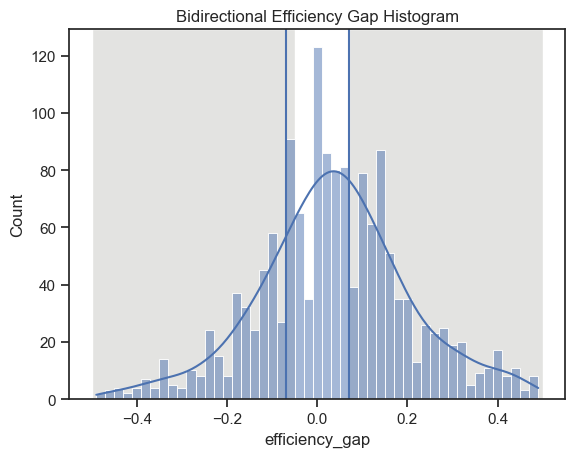

In [382]:
# Shading
plt.axvline(x=0.07)
plt.axvline(x=-0.07)
plt.axvspan(xmin=0.07, xmax=0.5, facecolor='#e3e3e1')
plt.axvspan(xmin=-0.5, xmax=-0.05, facecolor='#e3e3e1')

# Plot
sns.set_style('ticks')
g = sns.histplot(data=df_non_empty, x="efficiency_gap", binwidth=0.02, kde=True)
g.set_title("Bidirectional Efficiency Gap Histogram")

# Gridlines
# plt.grid()

## 2. Match maps to election return data for each district.

In [5]:
gdf = gpd.read_file("data/Precinct Shapes & Vote Results (election-geodata)/nation.gpkg")

In [8]:
gdf["year"].value_counts()

year
2016    115686
2010     50269
2014      7428
2012      6688
2017      5427
2013      2155
2011      1856
2018      1750
Name: count, dtype: int64

In [14]:
gdf_2016 = gdf[gdf["year"] == "2016"]

<Axes: >

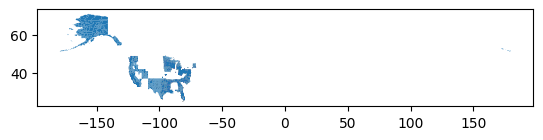

In [19]:
gdf_2016.plot()

Removing based on State FIPS (using reference from [US BLS](https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm))

In [59]:
# Removing all non-state territories with no right to vote (FIPS code > 56) 
# Removing six states with only one district - these states cannot be gerrymandered
removal_fips = ['02', '10', '38', '46', '50', '56', '60', '66', '69', '72', '78'] 

gov_gdf = gov_gdf[~gov_gdf["STATEFP20"].isin(removal_fips)]

# Check for remaining states
gov_gdf[~gov_gdf["STATEFP20"].isin(removal_fips)]["STATEFP20"].value_counts().index.sort_values()

Index(['01', '04', '05', '06', '08', '09', '10', '11', '12', '13', '16', '17',
       '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
       '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41',
       '42', '44', '45', '46', '47', '48', '49', '50', '51', '53', '54', '55',
       '56'],
      dtype='object', name='STATEFP20')

<Axes: >

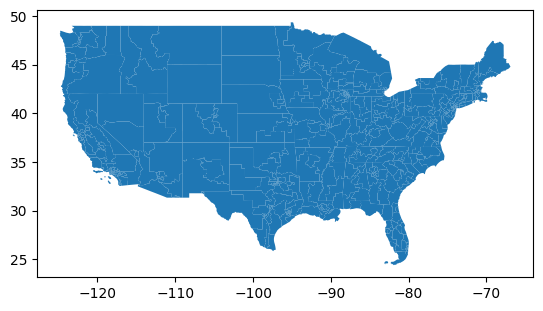

In [60]:
gov_gdf.plot()

In [49]:
gov_gdf[~gov_gdf["STATEFP20"].isin(external_state_fips)]["STATEFP20"].value_counts().index.sort_values()

Index(['01', '02', '04', '05', '06', '08', '09', '10', '11', '12', '13', '16',
       '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40',
       '41', '42', '44', '45', '46', '47', '48', '49', '50', '51', '53', '54',
       '55', '56'],
      dtype='object', name='STATEFP20')

In [57]:
gov_gdf[gov_gdf["STATEFP20"] == '02']

,STATEFP20,GEOID20,CD118FP,NAMELSAD20,LSAD20,CDSESSN,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,...,FLICKR_URL,PARTY,DISTRICT,STATE,VACANCY,ROOM_NUM,HOB,COMMITTEE_ASSIGNMENTS,LAST_UPDATED,geometry
7,02,0200,00,Congressional District (at Large),C1,118,G5200,N,1.478941e+12,2.453802e+11,...,,D,00,,0.0,153.0,CHOB,Natural Resources;Transportation,2023-04-18 09:36:37+00:00,"MULTIPOLYGON (((-168.23154 65.62624, -168.2318..."
